# Tacotron (with Dynamic Convolution Attention) for Afrikaans

A PyTorch implementation of [Location-Relative Attention Mechanisms For Robust Long-Form Speech Synthesis](https://arxiv.org/abs/1910.10288). 

Audio samples can be found [here](https://bshall.github.io/Tacotron/).

Demo for https://github.com/bshall/Tacotron

Install the necessary packages:

In [1]:
!pip install -q omegaconf
!pip install -q librosa==0.8.0
!pip install -q univoc
!pip install -q tacotron

In [2]:
import torch
import soundfile as sf
from univoc import Vocoder
from tacotron import text_to_id, Tacotron
import matplotlib.pyplot as plt
from IPython.display import Audio
from tqdm import tqdm as tqdm


def load_afrdict(file_name):
    """Loads the Afr(local) Pronouncing Dictionary"""

    dict_ref = file_name
    dict_file = open(dict_ref, 'r')
    dict_list = dict_file.readlines()
    dict_file.close()
    afrdict = {}
    for i in range(0, len(dict_list)):
        dict_list[i] = dict_list[i].strip().split()
        entry = " ".join([str(word) for word in dict_list[i][1:]])
        afrdict[str(dict_list[i][0])] = entry
    return afrdict

G2P Imports

In [3]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils import data
from torch.nn.utils.rnn import pack_padded_sequence
from g2pmodel import g2p_model_init as g2p_init
from demo_utils import process_text_input

In [4]:
afrdict_rcrl = load_afrdict("rcrl_apd.1.4.1.txt")
afrdict_afr_za = load_afrdict("afr_za_dict.txt")
afrdict_afr_za["boom"]
#afrdict["PYTORCH"] = "P AY1 T AO2 R CH"

'b u@ m'

In [6]:
g2p_model =  g2p_init()
model_params = "G2P/best_models/G2pLSTM-e256h256n2d0.1trainwitheval.pt"
g2p_model.load_state_dict(torch.load(model_params))
g2p_model.to("cuda:0")

cuda


G2PModel(
  (enc): Encoder(
    (embed): Embedding(43, 256)
    (dropout): Dropout(p=0.1, inplace=False)
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  )
  (dec): Decoder(
    (embed): Embedding(43, 256)
    (dropout): Dropout(p=0.1, inplace=False)
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
    (fc): Linear(in_features=256, out_features=43, bias=True)
  )
)

In [6]:
text = "142 drie"
process_text_input(g2p_model, afrdict_afr_za, text)

'een honderd twee en veertig drie'

Download pretrained weights for the vocoder and move to the GPU

In [7]:
vocoder = Vocoder.from_pretrained(
    "https://github.com/bshall/UniversalVocoding/releases/download/v0.2/univoc-ljspeech-7mtpaq.pt"
).cuda()

Download pretrained weights for tacotron - NaiveTTS and G2PxTTS

In [8]:
tacotron_naive = Tacotron.from_pretrained(
    "https://github.com/JulianHerreilers/pantoffel_tacotron_models_storage/releases/download/v0.190k-210k-230k-beta/model-230000.pt"
).cuda()

tacotron_G2P = Tacotron.from_pretrained(
    "https://github.com/JulianHerreilers/pantoffel_tacotron_models_storage/releases/download/v1.120epoch/model-300000.pt"
).cuda()

Load the CMU pronunciation dictionary and add the pronunciation of "PyTorch"

The text to be synthesized:

In [11]:
text = "league of legends is baie fun."
texta = "wys jou resultate in die tabel."

Synthesize the audio!

In [20]:
x = torch.LongTensor(text_to_id(texta, afrdict_rcrl)).unsqueeze(0).cuda()
with torch.no_grad():
    mel, alpha = tacotron_naive.generate(x)
    wav, sr = vocoder.generate(mel.transpose(1, 2))
Audio(wav, rate=sr)

Text(0, 0.5, 'Encoder steps')

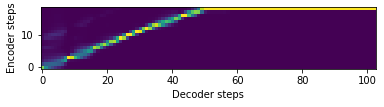

In [17]:
plt.imshow(alpha.squeeze().cpu().numpy(), vmin=0, vmax=0.8, origin="lower")
plt.xlabel("Decoder steps")
plt.ylabel("Encoder steps")

In [ ]:
plt.plot(wav)

In [12]:
#text = "league of legends is baie fun!"
text = process_text_input(g2p_model, afrdict_afr_za, text)
x = torch.LongTensor(text_to_id(text, afrdict_afr_za)).unsqueeze(0).cuda()
with torch.no_grad():
    mel, alpha = tacotron_G2P.generate(x)
    wav, sr = vocoder.generate(mel.transpose(1, 2))
Audio(wav, rate=sr)

In [ ]:
plt.imshow(alpha.squeeze().cpu().numpy(), vmin=0, vmax=0.8, origin="lower")
plt.xlabel("Decoder steps")
plt.ylabel("Encoder steps")

In [ ]:
plt.plot(wav)

Listen to the results (IPython normalizes the audio so the result is louder than it would normally be)

and plot the attention matrix